# Combined Data

This notebook was loaded with:

```bash
PYSPARK_DRIVER_PYTHON=jupyter PYSPARK_DRIVER_PYTHON_OPTS=notebook ./dse/bin/dse pyspark --num-executors 5 --driver-memory 6g --executor-memory 6g
```

We've already done some exploration in the Exploration notebook. Now, we'll clean the data and load it into Cassandra for use in MLLib model building jobs later.

In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [25]:
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import count, datediff, lag, sum, coalesce, rank, lit, when,col, udf, to_date, year, mean, month, date_format, array
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, DateType
from pyspark.ml.feature import StringIndexer
from datetime import datetime
from pyspark.sql.window import Window
import pyspark
import matplotlib
import matplotlib.pyplot as plt

Now, we can start working with it... let's load it into the spark context

In [5]:
df_inspections = sqlContext.read.format("org.apache.spark.sql.cassandra").\
               load(keyspace="chicago_data", table="inspections")

In [15]:
df_licenses = sqlContext.read.format("org.apache.spark.sql.cassandra").\
               load(keyspace="chicago_data", table="licenses")
    
df_licenses = df_licenses.drop("latitude")
df_licenses = df_licenses.drop("longitude")

In [16]:
df_joined = df_inspections.join(df_licenses, on="license_id", how="left")

In [17]:
df_joined.columns

['license_id',
 'inspection_dt',
 'canvass',
 'child',
 'closeup',
 'complaint',
 'cumulative_failures',
 'cumulative_inspections',
 'days_since_last_inspection',
 'ever_failed',
 'inspection_date_string',
 'inspection_type',
 'inspection_type_descr',
 'inspection_type_description',
 'latitude',
 'license',
 'liquor',
 'longitude',
 'no_entry',
 'prev_fail',
 'proportion_past_failures',
 'recent_inspection',
 'reinspection',
 'risk',
 'risk_description',
 'special_event',
 'task_force',
 'y',
 'y_description',
 'y_fail',
 'zip',
 'id',
 'account_number',
 'address',
 'application_created_date',
 'application_requirements_complete',
 'application_type',
 'business_activity',
 'business_activity_id',
 'conditional_approval',
 'doing_business_as_name',
 'legal_name',
 'license_approved_for_issuance',
 'license_code',
 'license_description',
 'license_number',
 'license_status_change_date',
 'license_term_expiration_date',
 'license_term_start_date',
 'payment_date',
 'police_district',
 '

In [38]:
# Group by
#add a 1 to each record to that we can get a total number of inspections
df_joined = df_joined.withColumn("inspected", lit(1))

#group the results
group = df_joined.select("police_district","y_fail", "inspected").groupby('police_district') \
            .sum('y_fail', 'inspected') \
            .withColumn("prop", col("sum(y_fail)") / col("sum(inspected)")) \
            .select(col("police_district"), col("prop")) \
            .orderBy("prop", ascending=False)

In [40]:
group.head(5)

[Row(police_district=u'5', prop=0.3548387096774194),
 Row(police_district=u'15', prop=0.32075471698113206),
 Row(police_district=u'10', prop=0.3103448275862069),
 Row(police_district=u'12', prop=0.2638522427440633),
 Row(police_district=u'6', prop=0.24778761061946902)]

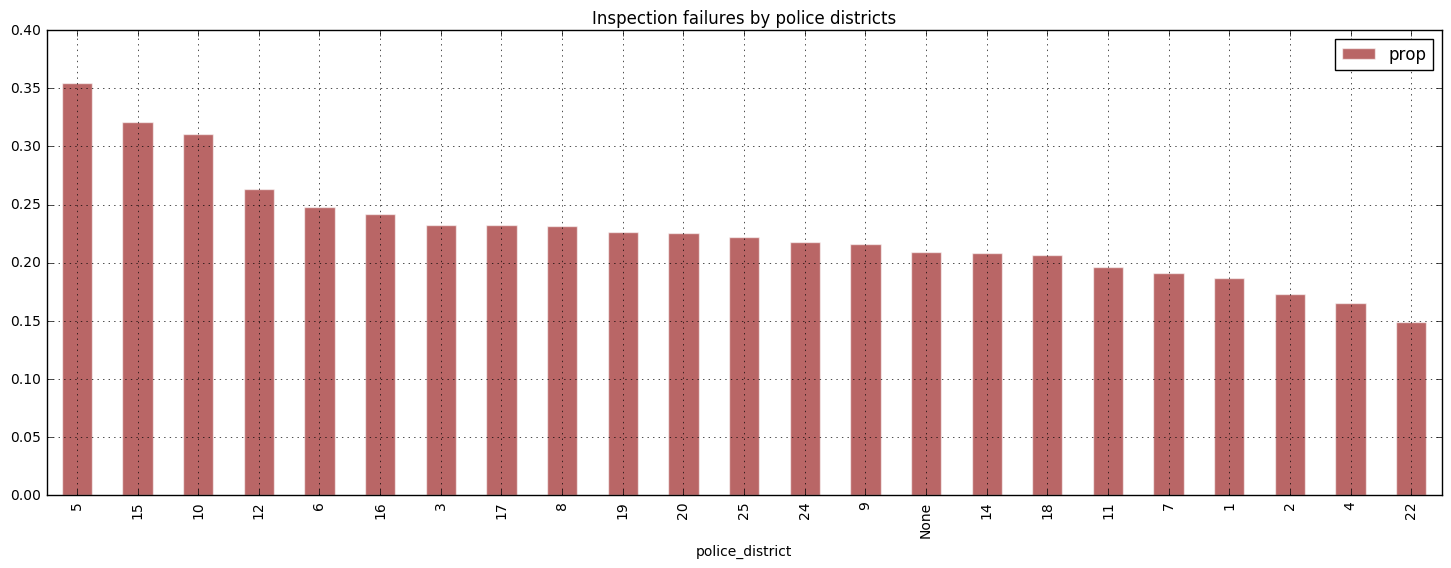

In [42]:
my_grouping = group.toPandas()
plt = my_grouping.plot(x="police_district", y="prop",kind='bar', color='darkred', alpha=0.6, edgecolor='white', title='Inspection failures by police districts', figsize=(18, 6))
plt.grid()

It's interesting that 5 leads the way, followed by 15 and 10. Districts 8, 11, and 25 lead the way in crime, but are about average in terms of failures.

In [51]:
 df_test.write\
    .format("org.apache.spark.sql.cassandra")\
    .mode('append')\
    .options(table="inspections", keyspace="chicago_data")\
    .save()